In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import psfws
import datetime


plt.rcParams['font.size']=13
plt.rcParams['axes.labelsize']=15
plt.rcParams['axes.titlesize']=15

In [2]:
# try using draw_datapoint()
def add_datetime1(df):
    """get date time using draw_datapoint"""
    # extracting datetime this way does take a long time
    dt = []
    for i in range(len(df)):
        seed = atm.iloc[i].name
        time = psfws.ParameterGenerator(seed).draw_datapoint()
        dt.append(time)
    df["datetime"] = dt
    df['month'] = [dt[i].month for i in range(len(dt))]
    df['day'] = [dt[i].day for i in range(len(dt))]
    df['hour'] = [dt[i].hour for i in range(len(dt))]
    return dt,df


def get_summaries(path):
    """get data for size, ellipticity, atm"""
    f_psfws = ["size_summary_psfws_df.p", "e1_summary_psfws_df.p", "e2_summary_psfws_df.p","atm_summary_psfws_df.p"]
    size, e1, e2, atm = [pickle.load(open(path+f_psfws[i], "rb")) for i in range(4)]
    return size,e1,e2,atm



def add_datetime(df):
    """retrieve datetime"""
    seed = 771963
    ws = psfws.ParameterGenerator(seed=seed)
    data_fa = ws.__getattribute__("data_fa")

    time = [data_fa.index[i] for i in range(len(data_fa))]
    speeds = {}
    for i in range(len(data_fa)):
        speeds[time[i]] = ws.get_parameters(time[i],nl=6, location="com")['speed']

    dt = []
    for i in range(len(df)):
        for j in range(len(time)):
            if all(df["speed"].iloc[i] == speeds[time[j]]):
                dt.append(time[j])
    df["datetime"] = dt
    df['month'] = [dt[i].month for i in range(len(dt))]
    df['day'] = [dt[i].day for i in range(len(dt))]
    df['hour'] = [dt[i].hour for i in range(len(dt))]
    return dt,df


def plotStepHist(ax,para,binn,change_axis=False, lbl=""):
    """plot step histogram """
    y, bin_edges, _ = ax.hist(para, bins=binn, histtype='step', color="salmon")
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    if change_axis:
        bin_centers = [x+90 if x<90 else x-90 for x in bin_centers]
    return ax


def plot_atm_dist(dt):
    """plot distribution of month, day, hour"""
    fig,ax = plt.subplots(1,3,figsize=(15,4))
    ax[0] = plotStepHist(ax[0], [dt[i].month for i in range(len(dt))],np.arange(1,13))
    ax[0].set_xticks(np.arange(1,13,2))
    ax[0].set_xlabel("Month")

    ax[1] = plotStepHist(ax[1], [dt[i].day for i in range(len(dt))],np.arange(1,32))
    ax[1].set_xticks(np.arange(1,32,5))
    ax[1].set_xlabel("Date")

    ax[2] = plotStepHist(ax[2], [dt[i].hour for i in range(len(dt))],np.arange(0,25))
    ax[2].set_xticks(np.arange(0,25,5))
    ax[2].set_xlabel("Hour (UTC)")

    fig.suptitle("Date time distribution of psfws simulations")
    fig.tight_layout();

In [95]:
# plot angles
def plot_dt_angles(para):
    """plot 2pcf angles"""
    fig,ax = plt.subplots(5,1,figsize=(8,8), sharex=True)
    lbls = ["size","e1","e2"]
    clr = ["darkseagreen","salmon","steelblue"]
    [ax[i].plot_date(para[i]["dt"],para[i]["2p_dir"],label=lbls[i],c=clr[i],linestyle="-",markersize=3.5, linewidth=0.4) for i in range(3)]
    ax[3].plot_date(atm['datetime'],atm['ground_dir'],label="ground dir",c="k",linestyle="-",markersize=3.5, linewidth=0.4)
    ax[4].plot_date(atm['datetime'],atm['meanDir'],label="mean free atm",c="palevioletred",linestyle="-",markersize=3.5, linewidth=0.4)
    [ax[i].legend(loc="lower left") for i in range(5)]
    [ax[i].set_ylim((0,180)) for i in range(5)]
    ax[1].set_ylabel("2pcf angles") 
    fig.tight_layout()
    #fig.savefig("2pcfAngles.pdf")
    ;
    
    
    
def plot_dt_angles50(para50):
    """plot 2pcf angles<50 with ground wind"""
    fig,ax = plt.subplots(3,1,figsize=(10,8), sharex=True)
    lbls = ["size","e1","e2"]
    clr = ["darkseagreen","salmon","steelblue"]
    [ax[i].plot_date(para50[i]["dt"],para50[i]["2p_dir"],label=lbls[i],c=clr[i],markersize=3.5) for i in range(3)]
    [ax[i].plot_date(atm['datetime'],atm['ground_dir'],label="ground wind dir",c="k",linestyle="-",markersize=3.5, linewidth=0.4)for i in range(3)]
    fig.legend()
    fig.suptitle("Angles < 50 degrees")
    ax[1].set_ylabel("2pcf angles") 
    fig.tight_layout()
    ;
    
    
def plot_autocorr(hrs,months,autocorrM,autocorrH):
    """plot 2pcf mean auto-correlation"""
    fig, ax = plt.subplots(1,3,figsize=(12,4),sharex=True, sharey=True)
    for j in range(3):
        ax[j].scatter(months,autocorrM[j],c="salmon", linewidth=1)
        ax[j].set_xticks([5,6,7,8,9,10])
        ax[j].ticklabel_format(axis="y",scilimits=(0,0))
        ax[j].set_title(['size',"e1","e2"][j])
    fig.suptitle("2pcf mean autocorrelation, by month")
    fig.tight_layout();

    fig, ax = plt.subplots(1,3,figsize=(12,4),sharex=True, sharey=True)
    for j in range(3):
        for i in range(3):
            ax[j].scatter(hrs,autocorrH[j],c="salmon", linewidth=1)
            ax[j].set_xticks([0,3,6,12,18])
            ax[j].ticklabel_format(axis="y",scilimits=(0,0))
            ax[j].set_title(['size',"e1","e2"][j])
    fig.suptitle("2pcf mean autocorrelation, by hour")
    fig.tight_layout();

    
def plot_dt_corrLen(para):
    """plot 2pcf correlation length"""
    fig,ax = plt.subplots(3,1,figsize=(8,6), sharex=True, sharey=True)
    lbls = ["size","e1","e2"]
    clr = ["darkseagreen","salmon","steelblue"]
    [ax[i].plot_date(para[i]["dt"],para[i]["2p_sig"],label=lbls[i],c=clr[i],linestyle="-",markersize=3.5, linewidth=0.5) for i in range(3)]
    fig.legend(bbox_to_anchor=(1.15,0.6))
    ax[1].set_ylabel("correlation length") 
    fig.suptitle("2pcf correlation length, by date time")
    fig.tight_layout()
    ;

In [38]:
#Plot date,time distributions
path = "summariesCircle/"
size,e1,e2,atm = get_summaries(path)
dt, atm = add_datetime(atm)

# add date time to size, e1, e2, atm dfs and sort by datetime
para = [size,e1,e2]
size["dt"], e1["dt"], e2["dt"] = dt, dt, dt
[para[i].sort_values(by="dt",inplace=True) for i in range(3)]

#get ground wind direction
atm["ground_dir"] = [atm.iloc[i]['direction'][0].deg for i in range(len(atm))]

#get free atm mean velocity vector
meanDir = np.zeros(len(atm))
for j in range(len(atm)):
    vx = np.mean([atm.iloc[j]['speed'][i]*np.cos(atm.iloc[j]['direction'][i]) for i in range(1,6)])
    vy = np.mean([atm.iloc[j]['speed'][i]*np.sin(atm.iloc[j]['direction'][i]) for i in range(1,6)])
    meanDir[j] = np.arctan2(vy,vx)*180/np.pi
atm['meanDir'] = meanDir
atm.sort_values(by="datetime",inplace=True);

# get angles <50
#para50 = [para[i][para[i]['2p_dir'] <50] for i in range(3)]

#get mean autocorr
hrs = [0,6,18]
months = np.arange(5,11)
autocorrM = [[para[i][atm['month']==j]['autocorr'].mean() for j in months] for i in range(3)]
autocorrH = [[para[i][atm['hour']==j]['autocorr'].mean() for j in hrs] for i in range(3)]

In [39]:
atm

,r0_500,L0,speed,direction,altitude,r0_weights,screen_size,screen_scale,rng,datetime,month,day,hour,ground_dir,meanDir
27,0.097374,"[50.499070527216425, 50.499070527216425, 50.49...","[0.6000000000000001, 8.810443512751963, 23.921...","[2.8099800957108707 radians, 3.814900905500551...","[0.2, 2.855171145018949, 8.251428674087627, 10...","[4.2562020712399874e-13, 5.431266181502611e-14...",717.636790,0.1,galsim.BaseDeviate('3390773751 3812675937 1783...,2019-05-01 06:00:00+00:00,5,1,6,161.0,-138.075527
108,0.056757,"[14.284082102580092, 14.284082102580092, 14.28...","[6.2, 10.081061762747105, 19.826159479340344, ...","[4.948008429403925 radians, 4.009107424477496 ...","[0.2, 2.382178626497187, 8.114177279256603, 11...","[8.153307832660524e-13, 4.777631780002552e-14,...",598.018681,0.1,galsim.BaseDeviate('2692648253 2084401400 1427...,2019-05-01 18:00:00+00:00,5,1,18,283.5,-140.928765
142,0.078156,"[51.40030899080719, 51.40030899080719, 51.4003...","[7.85, 19.982055026457612, 32.46170997712302, ...","[5.122541354603357 radians, 5.033605559755825 ...","[0.2, 2.0046710980667015, 7.059867873848428, 1...","[2.0482374205231513e-13, 1.3551873179690142e-1...",973.851299,0.1,galsim.BaseDeviate('3122296126 433151177 24117...,2019-05-03 18:00:00+00:00,5,3,18,293.5,-80.296077
123,0.087482,"[15.678376430349866, 15.678376430349866, 15.67...","[7.85, 19.982055026457612, 32.46170997712302, ...","[5.122541354603357 radians, 5.033605559755825 ...","[0.2, 2.0046710980667015, 7.059867873848428, 1...","[5.20003102215666e-13, 6.559833686701024e-14, ...",973.851299,0.1,galsim.BaseDeviate('1952064878 4288818152 4226...,2019-05-03 18:00:00+00:00,5,3,18,293.5,-80.296077
23,0.080339,"[58.44555817312583, 58.44555817312583, 58.4455...","[10.0, 27.569752894494624, 50.240330872803405,...","[5.288347633542818 radians, 5.529696504647009 ...","[0.2, 2.554818861839018, 7.958082507240019, 11...","[2.2573625914739668e-13, 1.0659842651958753e-1...",1350.000000,0.1,galsim.BaseDeviate('2206697241 2172829892 3744...,2019-05-07 06:00:00+00:00,5,7,6,303.0,-60.517848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,0.073440,"[16.56497362939298, 16.56497362939298, 16.5649...","[4.2, 15.25537918141427, 44.14238050321658, 37...","[4.904375198104066 radians, 4.43023226478147 r...","[0.2, 2.444265284088913, 7.747609946037602, 11...","[2.2491744950857556e-13, 1.1921399777090995e-1...",1324.271415,0.1,galsim.BaseDeviate('2680343733 342471504 11718...,2019-10-25 00:00:00+00:00,10,25,0,281.0,-101.229096
39,0.126324,"[61.352134942139614, 61.352134942139614, 61.35...","[8.3, 20.709766048878983, 39.040687738153274, ...","[5.340707511102648 radians, 4.957554784174459 ...","[0.2, 2.1617811118276187, 7.55632651924386, 12...","[2.6211259929479245e-13, 1.1031327815768752e-1...",1318.236010,0.1,galsim.BaseDeviate('3179634752 2683325479 1670...,2019-10-27 00:00:00+00:00,10,27,0,306.0,-82.612124
156,0.057297,"[27.864722066248213, 27.864722066248213, 27.86...","[8.3, 20.709766048878983, 39.040687738153274, ...","[5.340707511102648 radians, 4.957554784174459 ...","[0.2, 2.1617811118276187, 7.55632651924386, 12...","[1.2172855103203764e-13, 9.100384251302258e-14...",1318.236010,0.1,galsim.BaseDeviate('231689142 1011303659 40672...,2019-10-27 00:00:00+00:00,10,27,0,306.0,-82.612124
136,0.082375,"[15.329811991204197, 15.329811991204197, 15.32...","[11.7, 31.567660965728994, 52.63710680058311, ...","[5.305800926062762 radians, 4.986609289688606 ...","[0.2, 2.102408533144314, 8.090007506365543, 12...","[5.593274150245074e-13, 2.1449953794908185e-14...",1350.000000,0.1,galsim.BaseDeviate('49052405 1842126790 632129...,2019-10-29 06:00:00+00:00,10,29,6,304.0,-75.939432


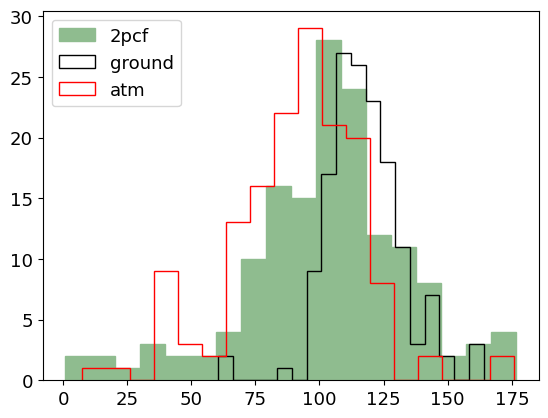

In [104]:
plt.hist((90-size["2p_dir"])%180,fill=True,color='darkseagreen',label='2pcf',histtype='step',bins=18)
plt.hist(atm['ground_dir']%180,fill=False,edgecolor='k',histtype='step',label='ground',bins=18)
plt.hist(atm['meanDir']%180,fill=False,edgecolor='red',histtype='step',label='atm',bins=18)
plt.legend();

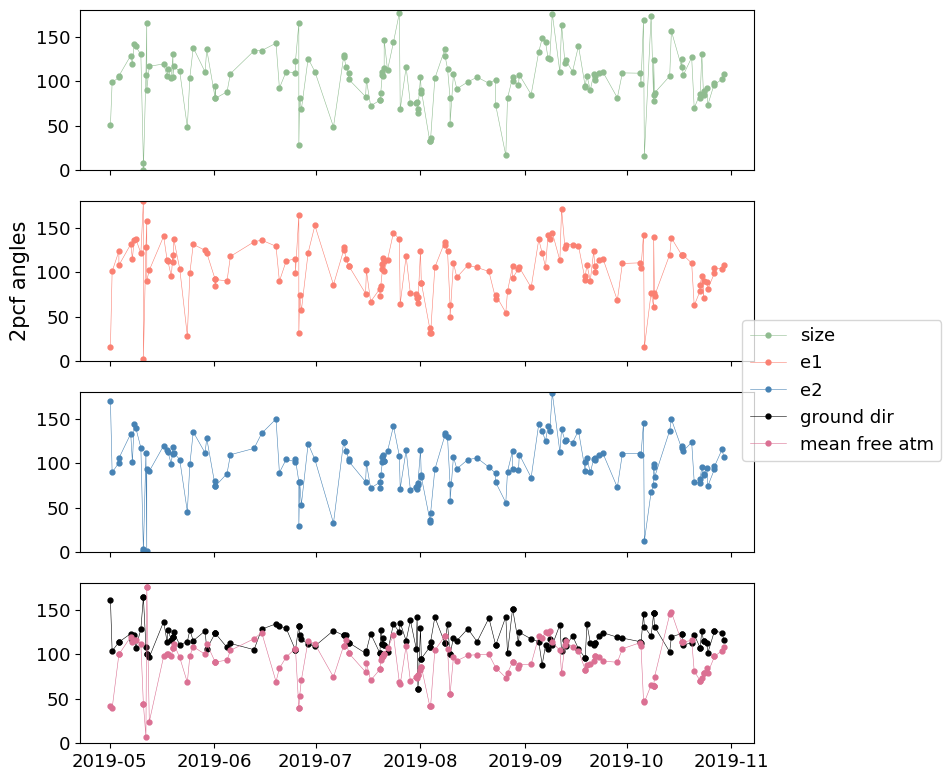

In [93]:
def plot_dt_angles(para):
    """plot 2pcf angles"""
    fig,ax = plt.subplots(4,1,figsize=(8,8), sharex=True)
    lbls = ["size","e1","e2"]
    clr = ["darkseagreen","salmon","steelblue"]
    [ax[i].plot_date(para[i]["dt"],(90-para[i]["2p_dir"])%180,label=lbls[i],c=clr[i],linestyle="-",markersize=3.5, linewidth=0.4) for i in range(3)]
    ax[3].plot_date(atm['datetime'],atm['ground_dir']%180,label="ground dir",c="k",linestyle="-",markersize=3.5, linewidth=0.4)
    ax[3].plot_date(atm['datetime'],atm['meanDir']%180,label="mean free atm",c="palevioletred",linestyle="-",markersize=3.5, linewidth=0.4)
    #[ax[i].legend(loc="lower left") for i in range(5)]
    [ax[i].set_ylim((0,180)) for i in range(4)]
    ax[1].set_ylabel("2pcf angles") 
    fig.legend(loc="center right", bbox_to_anchor=(1.2,0.5))
    fig.tight_layout()
    #fig.savefig("2pcfAngles.pdf")
    ;

plot_dt_angles(para)

'\nplt.rcParams[\'font.size\']=10\nsai = size.head(10)\nplt.figure(figsize=(12,4))\nplt.plot_date(sai["dt"],sai["2p_dir"]);\n'

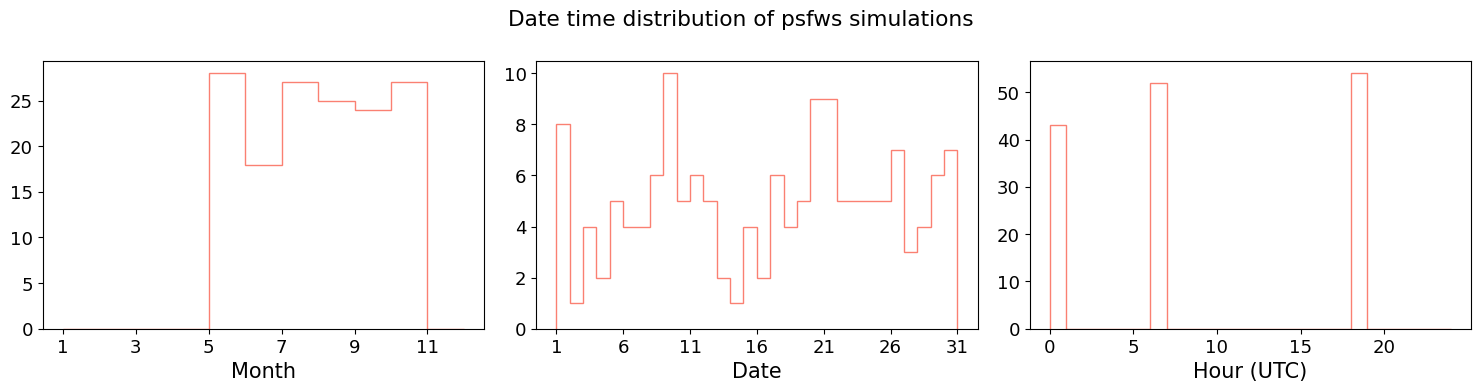

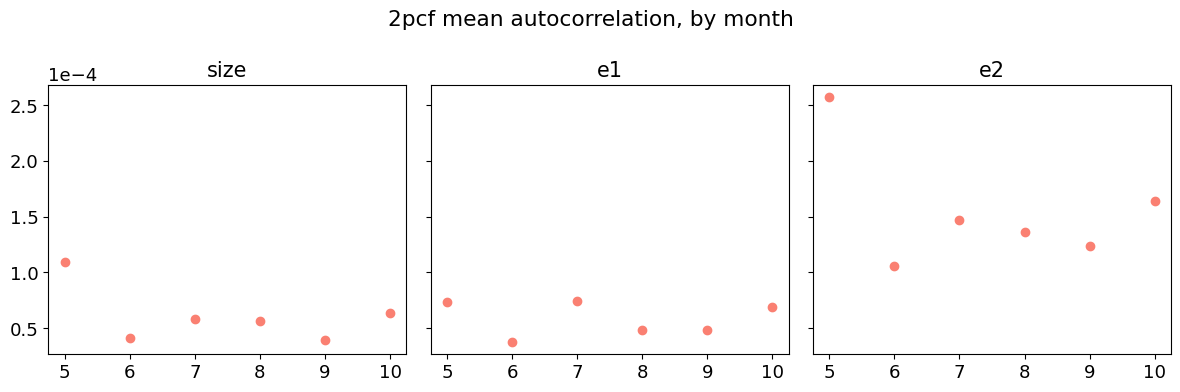

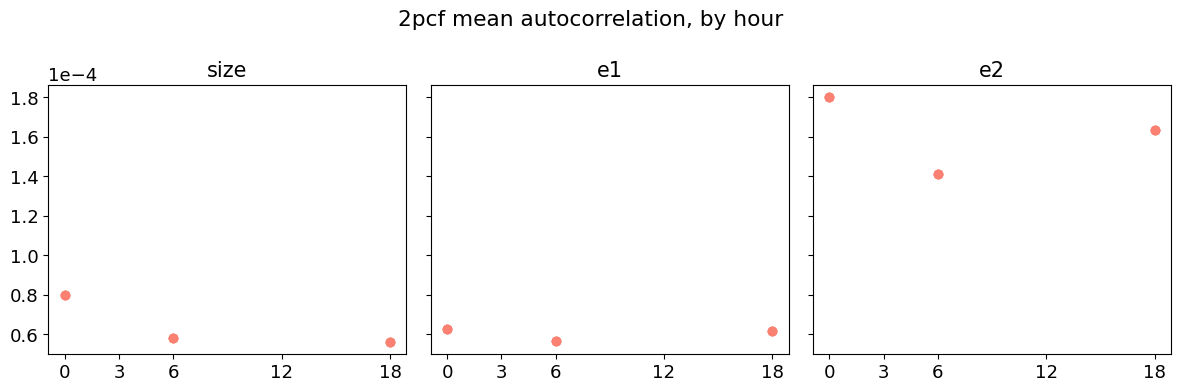

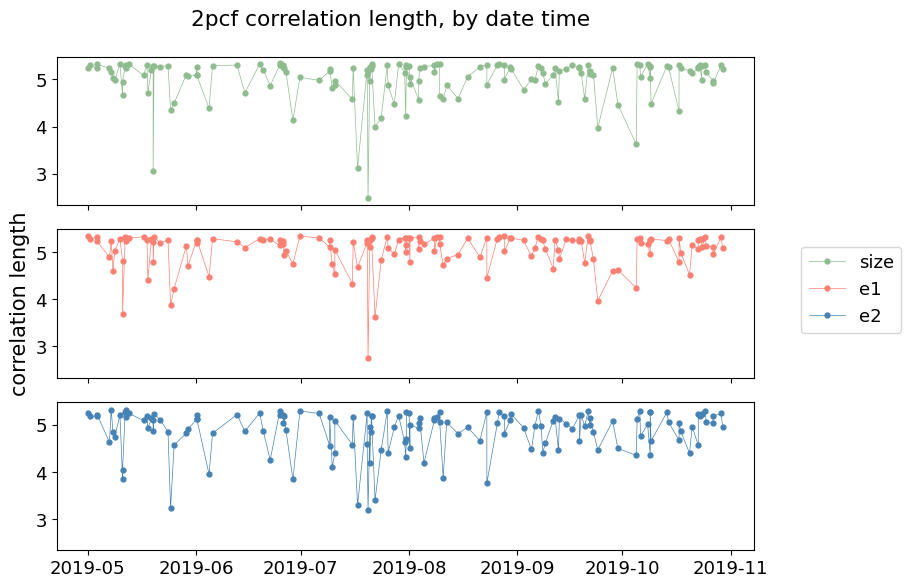

In [96]:
plot_atm_dist(dt)
plot_autocorr(hrs,months,autocorrM,autocorrH)
plot_dt_corrLen(para)